# cGAN transformer reconstruct


In [ ]:
!pip install open3d &> /dev/null

In [ ]:
import os
import io
import cv2
import copy
import math
import random
import numpy as np
import pickle as pkl
import open3d as o3d
from collections import deque
from tqdm import tqdm, trange
from typing import Optional, Any, Deque, Dict, List, Tuple

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from torch import Tensor
from torch.nn.modules.module import Module
from torch.nn.modules.activation import MultiheadAttention
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split


## hyper parameters

This colab is only a training example. colab GPU memory is not enough for this model. 
* Recommend to use local runtime on larger work station
* Recommend to use Tesla-V100 and set the epoch=100, batch_size=24
* setting epoch=1, batch_size=4.



In [ ]:
parameters = dict(
    batch_size=4,
    nhead_attention=8,
    encoder_layer=6,
    decoder_layer=6,
    feature_dim=7,
    embed_dim=64,
    patch_size=1,
    epoch=1,
    beta1=0.5,
    learning_rate=3e-4,
    lambda_l1=1,
    vis_num=4,
    visualize_epoch=2,
)
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
config = Struct(**parameters)

## download & prepare dataset

In [ ]:
!gdown --id 1ICXu_HUp7iL_VwBbEmaqkGQ44xgwjD39
!unzip -o -q pkl.zip

Downloading...
From: https://drive.google.com/uc?id=1ICXu_HUp7iL_VwBbEmaqkGQ44xgwjD39
To: /content/pkl.zip
436MB [00:05, 80.2MB/s]


radar points size is not static.

use rnn_utils.pack_padded_sequence to pack each datapoint
https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html


In [ ]:
# rnn_utils.pack_sequence
def collate_fn(batch):
    lidar = torch.Tensor([item[0] for item in batch])
    radar = [torch.Tensor(item[1]) for item in batch]

    lengths = torch.Tensor([len(r) for r in radar])

    radar = rnn_utils.pad_sequence(radar, batch_first=False, padding_value=0)
    radar = rnn_utils.pack_padded_sequence(
        radar, lengths, batch_first=False, enforce_sorted=False)

    return lidar, radar


In [ ]:
class RadarDataset(Dataset):
    def __init__(
        self,
        folder='/content/pkl/',
        remove_oulier=None,
        scene='all',
    ):
        scene_files = {
            'corridor': [
                '0717_1411','0720_1129','0722_1428','0722_1437','0722_1448',
                '0722_1500','0722_1506','0722_1510','0722_1514','0724_1101',
                '0724_1132','0724_1204','0727_1005','0727_1027','0727_1102',
                '0727_1435','0727_1452','0727_1510','0727_1520','0805_1108',
                '0805_1127','0805_1147'
            ],
            'parking': [
                '0717_1504','0720_1105','0805_1349','0805_1425'
            ]
        }
        paths = []
        allfiles = os.listdir(folder)
        allfiles.sort()
        files = []
        print('scene: ', scene)

        if scene=='all':
          files = allfiles
        else:
          for f in allfiles:
            if f[-4:] == '.pkl' and any(s in f for s in scene_files[scene]):
              files.append(f)

        self.data = []
        for f in files:
            with open(folder+f, 'rb') as h:
                self.data.extend(pkl.load(h))
        print('dataset loaded, length:%d' % len(self.data))

        self.remove_oulier = remove_oulier
        if remove_oulier is not None:
            print('remove outlier=%f' % remove_oulier)

    def __getitem__(self, index):

        d = self.data[index]

        # t = d[0]
        lidar = d[1:242]
        radar = d[242:].reshape(-1, 7)

        if self.remove_oulier is not None:
            pt = radar[:, 2:5]
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pt)
            cl, ind = pcd.remove_radius_outlier(
                nb_points=1, radius=self.remove_oulier)
            radar = radar[ind]

        return lidar, radar

    def __len__(self):
        return len(self.data)

In [ ]:
radar_dataset = RadarDataset(scene='all')

train_loader = DataLoader(
    dataset=radar_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn,
)

scene:  all

dataset loaded, length:113431


## custom Transformer layer
inorder to retrieve attention map, modify transformer layer from pytorch source code

https://pytorch.org/docs/stable/nn.html#transformer-layers

In [ ]:
#@title Original Transformer Archietecture
#@markdown <img src="https://drive.google.com/uc?id=1duAOs6oUsgQg2MnqeK2A9U3ZgsbAKalq" alt="mha" height="700"/>
#@markdown <img src="https://drive.google.com/uc?id=1sSEmh4vyY97ZXKKDme2jEEjbsFERx8PU" alt="mha" height="350"/>

class TransformerEncoder(Module):
    r"""TransformerEncoder is a stack of N encoder layers
    Args:
        encoder_layer: an instance of the TransformerEncoderLayer() class (required).
        num_layers: the number of sub-encoder-layers in the encoder (required).
        norm: the layer normalization component (optional).
    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        >>> src = torch.rand(10, 32, 512)
        >>> out = transformer_encoder(src)
    """
    __constants__ = ['norm']

    def __init__(self, encoder_layer, num_layers, norm=None):
        super(TransformerEncoder, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src: Tensor, mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layers in turn.
        Args:
            src: the sequence to the encoder (required).
            mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).
        Shape:
            see the docs in Transformer class.
        """
        output = src

        attention_maps = None

        for mod in self.layers:
            output, att_map = mod(
                output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

            att_map = torch.unsqueeze(att_map, dim=1)
            if attention_maps is None:
                attention_maps = att_map
            else:
                attention_maps = torch.cat((attention_maps, att_map), dim=1)

        if self.norm is not None:
            output = self.norm(output)

        return output, attention_maps


class TransformerDecoder(Module):
    r"""TransformerDecoder is a stack of N decoder layers
    Args:
        decoder_layer: an instance of the TransformerDecoderLayer() class (required).
        num_layers: the number of sub-decoder-layers in the decoder (required).
        norm: the layer normalization component (optional).
    Examples::
        >>> decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
        >>> transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
        >>> memory = torch.rand(10, 32, 512)
        >>> tgt = torch.rand(20, 32, 512)
        >>> out = transformer_decoder(tgt, memory)
    """
    __constants__ = ['norm']

    def __init__(self, decoder_layer, num_layers, norm=None):
        super(TransformerDecoder, self).__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the inputs (and mask) through the decoder layer in turn.
        Args:
            tgt: the sequence to the decoder (required).
            memory: the sequence from the last layer of the encoder (required).
            tgt_mask: the mask for the tgt sequence (optional).
            memory_mask: the mask for the memory sequence (optional).
            tgt_key_padding_mask: the mask for the tgt keys per batch (optional).
            memory_key_padding_mask: the mask for the memory keys per batch (optional).
        Shape:
            see the docs in Transformer class.
        """
        output = tgt

        attention_maps = None

        for mod in self.layers:
            output, att_map = mod(output, memory, tgt_mask=tgt_mask,
                                  memory_mask=memory_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask,
                                  memory_key_padding_mask=memory_key_padding_mask)

            att_map = torch.unsqueeze(att_map, dim=1)
            if attention_maps is None:
                attention_maps = att_map
            else:
                attention_maps = torch.cat((attention_maps, att_map), dim=1)

        if self.norm is not None:
            output = self.norm(output)

        return output, attention_maps


class TransformerEncoderLayer(Module):
    r"""TransformerEncoderLayer is made up of self-attn and feedforward network.
    This standard encoder layer is based on the paper "Attention Is All You Need".
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
    Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
    Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
    in a different way during application.
    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of intermediate layer, relu or gelu (default=relu).
    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> src = torch.rand(10, 32, 512)
        >>> out = encoder_layer(src)
    """

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerEncoderLayer, self).__setstate__(state)

    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layer.
        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).
        Shape:
            see the docs in Transformer class.
        """
        src2, attention_map = self.self_attn(src, src, src, attn_mask=src_mask,
                                             key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src, attention_map


class TransformerDecoderLayer(Module):
    r"""TransformerDecoderLayer is made up of self-attn, multi-head-attn and feedforward network.
    This standard decoder layer is based on the paper "Attention Is All You Need".
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
    Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
    Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
    in a different way during application.
    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of intermediate layer, relu or gelu (default=relu).
    Examples::
        >>> decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
        >>> memory = torch.rand(10, 32, 512)
        >>> tgt = torch.rand(20, 32, 512)
        >>> out = decoder_layer(tgt, memory)
    """

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = MultiheadAttention(
            d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.norm3 = LayerNorm(d_model)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)
        self.dropout3 = Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerDecoderLayer, self).__setstate__(state)

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None, memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None, memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the inputs (and mask) through the decoder layer.
        Args:
            tgt: the sequence to the decoder layer (required).
            memory: the sequence from the last layer of the encoder (required).
            tgt_mask: the mask for the tgt sequence (optional).
            memory_mask: the mask for the memory sequence (optional).
            tgt_key_padding_mask: the mask for the tgt keys per batch (optional).
            memory_key_padding_mask: the mask for the memory keys per batch (optional).
        Shape:
            see the docs in Transformer class.
        """
        tgt2 = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                                             key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2, attention_map = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt, attention_map


def _get_clones(module, N):
    return ModuleList([copy.deepcopy(module) for i in range(N)])


def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError(
        "activation should be relu/gelu, not {}".format(activation))

## radar trnasformer
using attention mechanism to process 3D mmWave points

### generator
transformer encoder+decoder

In [ ]:
#@title Generator L=6
#@markdown <img src="https://drive.google.com/uc?id=1QM7Jv3xGBEuptXsR5RetXcNRLdcXfieA" alt="netG" height="600"/>

class RadarTransformer(nn.Module):
    def __init__(
        self,
        features=7,
        embed_dim=64,
        nhead=8,
        encoder_layers=6,
        decoder_layers=6,
    ):
        super(RadarTransformer, self).__init__()

        # linear projection layer
        self.linear_projection = nn.Linear(features, embed_dim)

        # transformer encder block
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead
        )
        self.transformer_encoder = TransformerEncoder(
            encoder_layer,
            num_layers=encoder_layers
        )

        # decoder queries
        self.quries = nn.Parameter(torch.randn(241, 1, embed_dim))

        # transformer decoder layer
        decoder_layer = TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=nhead,
        )
        self.transformer_decoder = TransformerDecoder(
            decoder_layer,
            num_layers=decoder_layers,
        )

        # linear to output ranges
        self.linear_to_range = nn.Linear(embed_dim, 1)

    def forward(self, x, pad_mask, attention_map=False):
        n, b, _ = x.shape

        x = self.linear_projection(x)

        # transformer encoder
        x, ecd_att_map = self.transformer_encoder(
            x,
            src_key_padding_mask=pad_mask
        )
        # print(ecd_att_map.shape)

        # generate queries
        qur = self.quries.repeat(1, b, 1)

        # transformer decoder
        decoded, dcd_att_map = self.transformer_decoder(
            tgt=qur,
            memory=x,
            memory_key_padding_mask=pad_mask,
        )

        # project to ranges
        ranges = self.linear_to_range(decoded)
        ranges = torch.squeeze(ranges)
        if b>1:
            ranges = torch.transpose(ranges, 0, 1)

        if attention_map:
            return ranges, ecd_att_map, dcd_att_map
        else:
            return ranges

### discriminator
transformer decoder

In [ ]:
#@title Discriminator L=6
#@markdown <img src="https://drive.google.com/uc?id=1hAYq0GknCIa5LbGoBxOPBpDriWBAj70l" alt="netG" height="350"/>

class DiscriminatorTransform(nn.Module):
    def __init__(
        self,
        features=7,
        embed_dim=64,
        nhead=8,
        layers=6,
        patch_size=14,
    ):
        super(DiscriminatorTransform, self).__init__()

        # linear projection layer
        self.linear_projection = nn.Linear(features, embed_dim)
        self.linear_projection_laser = nn.Linear(1, embed_dim)

        # learnable extra token positioned
        self.patch_size = patch_size
        self.cls = nn.Parameter(torch.randn(patch_size, 1, embed_dim))

        # positional embedding for laser token
        self.pos_embedding = nn.Parameter(
            torch.randn(self.patch_size+241, 1, embed_dim))

        # transformer decoder block
        decoder_layer = TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=nhead,
        )
        self.transformer_decoder = TransformerDecoder(
            decoder_layer,
            num_layers=layers,
        )

        self.linear2patch = nn.Linear(embed_dim, 1)

    def forward(self, radar, pad_mask, laser, need_attention_map=False):
        n, b, _ = radar.shape

        radar = self.linear_projection(radar)

        laser = torch.transpose(laser, 0, 1)
        laser = torch.unsqueeze(laser, 2)
        laser = self.linear_projection_laser(laser)

        cls_tokens = self.cls.repeat(1, b, 1)

        # concat tokens to first position
        input_seq = torch.cat((cls_tokens, laser), dim=0)
        input_seq += self.pos_embedding

        # transformer encoder
        output_seq, dcd_att_map = self.transformer_decoder(
            tgt=input_seq,
            memory=radar,
            memory_key_padding_mask=pad_mask,
        )

        # cls head for patch gan
        cls_heads = output_seq[:self.patch_size, :, :]
        cls_heads = self.linear2patch(cls_heads)
        cls_heads = torch.transpose(cls_heads, 0, 1)
        cls_heads = torch.squeeze(cls_heads)

        return cls_heads

## train cGAN

### config

In [ ]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
print(device)

netG = RadarTransformer(
    features=config.feature_dim,
    embed_dim=config.embed_dim,
    nhead=config.nhead_attention,
    encoder_layers=config.encoder_layer,
    decoder_layers=config.decoder_layer,
).to(device)

netD = DiscriminatorTransform(
    features=config.feature_dim,
    embed_dim=config.embed_dim,
    nhead=config.nhead_attention,
    layers=config.decoder_layer,
    patch_size=config.patch_size,
).to(device)

# optimizers
optimizer_g = optim.Adam(netG.parameters(),
                         lr=config.learning_rate, betas=(config.beta1, 0.999))
optimizer_d = optim.Adam(netD.parameters(),
                         lr=config.learning_rate, betas=(config.beta1, 0.999))

# criterion
# gan_loss = nn.BCEWithLogitsLoss()
gan_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

cuda


### start

In [ ]:
def set_requires_grad(net, requires_grad=False):
    for param in net.parameters():
        param.requires_grad = requires_grad

In [ ]:
log_metrics = {
    'loss_D_real': [],
    'loss_D_fake': [],
    'loss_D': [],
    'loss_G_gan': [],
    'loss_G_l1': [],
    'loss_G': [],
}

step = 0
t = trange(config.epoch)

for epoch in t:
    for l, r in train_loader:
        b_size = l.size(0)

        seq_padded, lens = rnn_utils.pad_packed_sequence(r, batch_first=False)
        max_len = seq_padded.shape[0]
        pad_mask = torch.arange(max_len)[None, :] < lens[:, None]

        seq_padded = seq_padded.to(device)
        pad_mask = ~pad_mask.to(device)

        fake_y = netG(seq_padded, pad_mask)
        # fake_y = torch.unsqueeze(fake_y, 1)

        y = l.to(device)
        # y = torch.unsqueeze(y, 1)

        # patch size config.path_size
        fake_label = Variable(torch.Tensor(
            np.zeros((b_size))), requires_grad=False).to(device)
        real_label = Variable(torch.Tensor(
            np.ones((b_size))), requires_grad=False).to(device)

        ########################### train D ############################

        set_requires_grad(netD, True)
        optimizer_d.zero_grad()

        # fake
        pred_fake = netD(seq_padded, pad_mask, fake_y.detach())
        loss_D_fake = gan_loss(pred_fake, fake_label)

        # real
        pred_real = netD(seq_padded, pad_mask, y)
        loss_D_real = gan_loss(pred_real, real_label)

        # train
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        optimizer_d.step()

        ########################### train G ############################

        set_requires_grad(netD, False)
        optimizer_g.zero_grad()

        pred_fake = netD(seq_padded, pad_mask, fake_y)
        loss_G_gan = gan_loss(pred_fake, real_label)
        loss_G_l1 = l1_loss(fake_y, y) * config.lambda_l1
        loss_G = loss_G_gan + loss_G_l1
        loss_G.backward()
        optimizer_g.step()

        ########################### log ##################################

        log_metrics['loss_D_real'].append(loss_D_real.item())
        log_metrics['loss_D_fake'].append(loss_D_fake.item())
        log_metrics['loss_D'].append(loss_D.item())
        log_metrics['loss_G_gan'].append(loss_G_gan.item())
        log_metrics['loss_G_l1'].append(loss_G_l1.item())
        log_metrics['loss_G'].append(loss_G.item())

        step += 1
        t.set_description('step: %d' % step)

step: 28358: 100%|██████████| 1/1 [1:50:28<00:00, 6628.64s/it]


### logs
training example, learning curve for reference

the correct learning curve should look like

https://wandb.ai/juite/radar-transformer/runs/2jhysrga?workspace=user-juite

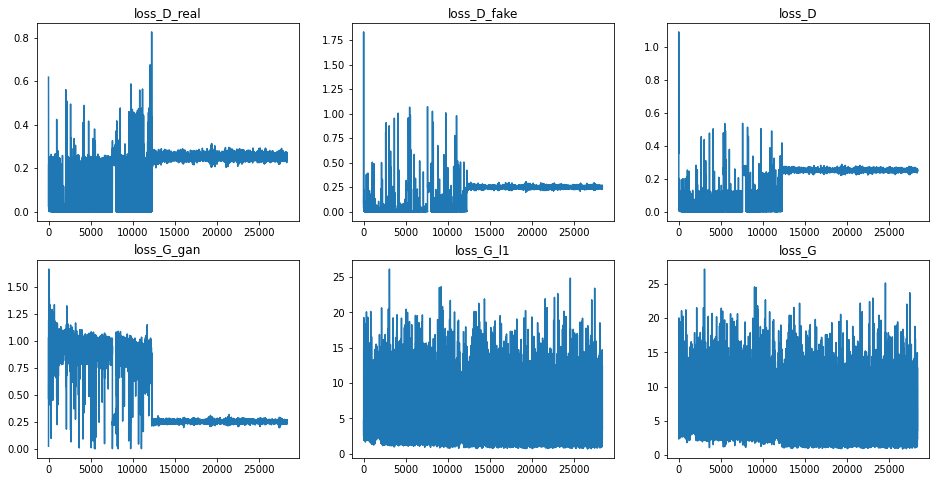

In [ ]:
fig = plt.figure(figsize=(16,8))
indx = 1
for k, v in log_metrics.items():
  ax = plt.subplot(2,3,indx)
  plt.title(k)
  plt.plot(np.arange(len(v)), v)
  indx+=1

## load pretrained model (optional)

In [ ]:
!gdown --id 10oRGq_-YIG3D-5BjPgg-RAGILhUZAsaO

Downloading...
From: https://drive.google.com/uc?id=10oRGq_-YIG3D-5BjPgg-RAGILhUZAsaO
To: /content/transformer_cgan.pth
14.0MB [00:00, 38.4MB/s]


In [ ]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
print(device)

netG = RadarTransformer(
    features=config.feature_dim,
    embed_dim=config.embed_dim,
    nhead=config.nhead_attention,
    encoder_layers=config.encoder_layer,
    decoder_layers=config.decoder_layer,
).to(device)

netG.load_state_dict(torch.load("/content/transformer_cgan.pth"))
netG.eval()


cuda


RadarTransformer(
  (linear_projection): Linear(in_features=7, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(i

## evaluation

In [ ]:
netG.eval()

l1_loss = nn.L1Loss()

scenes = ['corridor', 'parking']

for scene in scenes:
    dataset = RadarDataset(scene=scene)

    loader = DataLoader(
        dataset=dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn,
    )

    L1 = []
    for l, r in loader:
        b_size = l.size(0)

        seq_padded, lens = rnn_utils.pad_packed_sequence(r, batch_first=False)
        max_len = seq_padded.shape[0]
        pad_mask = torch.arange(max_len)[None, :] < lens[:, None]

        seq_padded = seq_padded.to(device)
        pad_mask = ~pad_mask.to(device)

        fake_y = netG(seq_padded, pad_mask).detach().cpu()

        fake_y = torch.clip(fake_y, 0, 5)
        l = torch.clip(l, 0, 5)
        loss_G_l1 = l1_loss(fake_y, l)
        L1.append(loss_G_l1)

    print('scene %s l1 loss: %.4f\n' % (scene, np.mean(L1)))


# cgan transformer accuracy in 100 meter
# scene corridor l1 loss: 0.6715
# scene parking l1 loss: 1.8636

# cgan transformer accuracy in 5 meter
# scene corridor l1 loss: 0.1271
# scene parking l1 loss: 0.1125


scene:  corridor

dataset loaded, length:74246
scene corridor l1 loss: 0.1271
scene:  parking

dataset loaded, length:16012
scene parking l1 loss: 0.1125


## visualization

In [ ]:
def laser_visual(lasers=[], names=[], range_limit=6):
  fig = plt.figure(figsize=(8, 8))
  colors=['#3483EB','#FFA500','#15B01D']
  for i, l in enumerate(lasers):
    angle = 120
    xp = []
    yp = []
    for r in l:
        if r <= range_limit:
            yp.append(r * math.cos(math.radians(angle)))
            xp.append(r * math.sin(math.radians(angle)))
        angle -= 1
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.plot(xp, yp, '.', color=colors[i], label=names[i])
  plt.legend(loc='lower right', fontsize=15)

In [ ]:
def filter(radar):
    min_h = 0.15
    max_h = 2
    pcd = o3d.geometry.PointCloud()
    pt = radar[:, 3:6]
    pcd.points = o3d.utility.Vector3dVector(pt)
    cl, ind = pcd.remove_radius_outlier(nb_points=3, radius=1.2)
    radar = radar[ind]
    radar = radar[np.where(radar[:, 5] > min_h)]
    radar = radar[np.where(radar[:, 5] < max_h)]
    return radar


In [ ]:
def pc_to_laser(pc):
    max_dis = 5
    min_angle = math.radians(-120)
    max_angle = math.radians(120)
    angle_incre = math.radians(0.9999)
    start_a = min_angle
    end_a = start_a + angle_incre

    angles = np.zeros(pc.shape[0])
    for i, p in enumerate(pc):
        angles[i] = math.atan2(p[1], p[0])

    laser = []
    while start_a < max_angle:
        bundle = pc[np.where((angles > start_a) & (angles < end_a))][:, :-1]
        if len(bundle) == 0:
            d = max_dis
        else:
            bundle = np.linalg.norm(bundle, axis=1)
            d = np.min(bundle)
            d = max_dis if d > max_dis else d
        laser.append(d)
        start_a += angle_incre
        end_a += angle_incre

    laser = np.array(laser)
    return laser

filter 3D mmWave points and project to 2D to visualize

visulization of the radar points is not the same as the input data

use rviz to better visualize on local work station

code: https://github.com/huangjuite/radar-transformer/blob/main/visualize_attention_auto.py

video: https://drive.google.com/file/d/1cvHwc_luf_vD-FJdDc5oiN7uxD43BIJ_/view?usp=sharing

data index:  4999


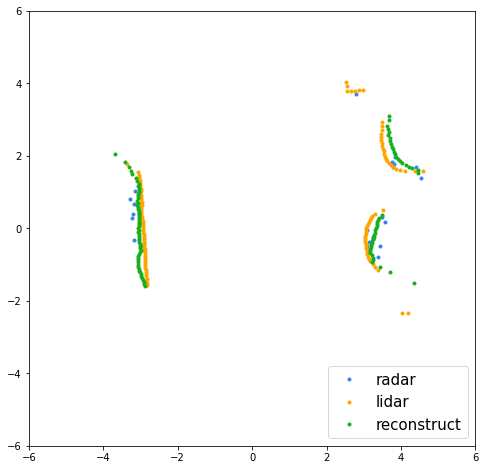

In [ ]:
# repeat this block to visualize different sample

indx = random.randint(0, len(radar_dataset)-1)
l, r = radar_dataset[indx]
print('data index: ', indx)
r_t = torch.Tensor(r).to(device)
r_t = torch.unsqueeze(r_t, dim=1)

l_t, encoder_attention, decoder_attention = netG(
    r_t, None, attention_map=True)
l_t = l_t.detach().cpu().numpy()
encoder_attention = encoder_attention.detach().cpu().numpy()[0]
decoder_attention = decoder_attention.detach().cpu().numpy()[0]

r = filter(r)
r_scan = pc_to_laser(r[:, 3:6])

laser_visual([r_scan, l, l_t], names=['radar', 'lidar', 'reconstruct'], range_limit=4.9)